In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1);
from torch.utils import data
import cv2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
from PIL import Image
from torch.utils import data
import os
from torch.utils.data import Subset, DataLoader
import random
from torchvision import transforms
random.seed(123)

In [5]:
class UCF_VIDEOS_DATASET(data.Dataset):
    
    def __init__(self, path_to_annotation, path_to_videos, seq_len):
        super(UCF_VIDEOS_DATASET, self).__init__()
        self.path_to_annotation = path_to_annotation
        self.path_to_videos = path_to_videos
        self.annotation_array = [] # [video_path, anomaly_frame] if anomaly_frame == -1 normal_video
        with open(path_to_annotation, 'r') as fp:
            for line in fp:
                splited_line = line.split("  ")
                if(splited_line[1] == "Explosion"):
                    self.annotation_array.append([splited_line[0], int(splited_line[2])])
                if(splited_line[1] == "Normal"):
                    self.annotation_array.append([splited_line[0], -1])        
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.annotation_array) - 1
        
    def __getitem__(self, item_idx):
        sequence_imgs = []
        sequence_labels = []
        step_size = 4
        frame_block_iter = 0
        frame_block_iter_length = 0
        frame_counter = 0
        video_name = self.annotation_array[item_idx][0]
        video_anomaly_frame = self.annotation_array[item_idx][1]
        cap = cv2.VideoCapture(os.path.join(self.path_to_videos, video_name))
        total_video_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        
        preprocess = transforms.Compose([
                                 transforms.Resize((224, 224)),
                                 #transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                 ])
        
        if video_anomaly_frame == -1:
            video_normal_frame = random.randint(int(total_video_frames / 4) , int(total_video_frames *3/4))
#             left_frames_length = video_normal_frame - 0
#             right_frames_length = total_video_frames - video_normal_frame
            start_frame = video_normal_frame
            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
            while True:
                ret, frame = cap.read()
                if(frame_block_iter % step_size == 0):
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame_pil = Image.fromarray(frame_rgb)
                    
                    sequence_labels.append(0)
        
                    sequence_imgs.append(preprocess(frame_pil)) 
                    
                    frame_block_iter = 0
                    frame_block_iter_length += 1
                frame_block_iter += 1
                if(frame_block_iter_length == self.seq_len): break
            
        if video_anomaly_frame != -1:
            left_frames_length = video_anomaly_frame - 0
            right_frames_length = total_video_frames - video_anomaly_frame
            # Если края меньше 4 секунд(В Explosion минимальная длина 9 секунд).
            # Так что максимальная длина 16 seq_len
            start_frame_delta = random.randint(0, ((self.seq_len - 1)  * step_size) - 1 ) + 1
            start_frame = video_anomaly_frame - start_frame_delta
            if left_frames_length < 4 * 30:
                start_frame_delta = random.randint(0, 19) + 1
                start_frame = video_anomaly_frame - start_frame_delta
                cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
            if left_frames_length < 4 * 30:
                start_frame_delta = random.randint((self.seq_len * step_size) - 20, (self.seq_len * step_size))
                start_frame = video_anomaly_frame - start_frame_delta
                cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
            frame_counter = start_frame
            while True:
                ret, frame = cap.read()
                if(frame_block_iter % step_size == 0):
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame_pil = Image.fromarray(frame_rgb)
                    
                    if(frame_counter < video_anomaly_frame):
                         sequence_labels.append(0)
                    else:
                        sequence_labels.append(1)
                        
                    sequence_imgs.append(preprocess(frame_pil)) 
                    
                    frame_block_iter = 0
                    frame_block_iter_length += 1
                frame_block_iter += 1
                frame_counter += 1
                #print(frame_block_iter_length)
                if(frame_block_iter_length == self.seq_len): break

        sequence_labels = np.asarray(sequence_labels)
        sequence_labels = torch.from_numpy(sequence_labels)

        sequence_imgs = torch.stack(sequence_imgs)
        
        return sequence_imgs, sequence_labels

In [6]:
path_to_videos = "Explosion/"
path_annotation_train = "UCF_train.txt"
path_annotation_validation = "UCF_validation.txt"
path_annotation_test = "UCF_test.txt"

In [7]:
imgs_dataset_train = UCF_VIDEOS_DATASET(path_annotation_train, path_to_videos, seq_len=16)
imgs_dataset_validation = UCF_VIDEOS_DATASET(path_annotation_validation, path_to_videos, seq_len=16)
imgs_dataset_test = UCF_VIDEOS_DATASET(path_annotation_test, path_to_videos, seq_len=16)

In [8]:
BATCH_SIZE = 8
train_dataloader = DataLoader(imgs_dataset_train, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(imgs_dataset_validation, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(imgs_dataset_test, batch_size=BATCH_SIZE)

In [9]:
# img_d = imgs_dataset_train[57]
# plt.imshow(  img_d[0][3].permute(1, 2, 0)  )
# print(img_d[1])


In [10]:
# plt.imshow(  img_d[0][1].permute(1, 2, 0)  )

In [11]:
# for iter in range(100):
#     for i in imgs_dataset_test:
#         print(len(i[0]), i[1], i[0].shape)

In [12]:
def loss_delay_detection_2(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0).to(device)
    loss = torch.arange(1, n + 1).to(device) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss


def loss_delay_detection(p_slice, w):
    n = p_slice.size(0) 
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    
    prod[1:] -= p_slice[:-1].to(device)
    cumprod = torch.cumprod(prod, dim=0).to(device)
    # TODO drop either n or w
    loss = (torch.arange(1, n + 1).to(device) * p_slice * cumprod 
            + (w + 1) * torch.prod(prod[1:]) * (1 - p_slice[-1]))
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice):
    length = len(p_slice)
    loss = 0
    
    start_ind = 0
    end_ind = 0
    
    while end_ind < length:
        start_ind = end_ind - 1
        if start_ind < 0:
            start_ind = 0
        end_ind = np.random.randint(start_ind, length + 2)
        if end_ind == start_ind:
            end_ind = end_ind + 1
        loss += 1 - loss_delay_detection_2(p_slice[start_ind: end_ind + 1])    
    #loss += 1 - loss_delay_detection_2(p_slice[start_ind: length])            
    loss = torch.sum(loss)
    return loss

In [13]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        loss = torch.zeros(labels.size(0))
        for i, label in enumerate(labels):
            ind = torch.where(label != label[0])[0]
            if ind.size()[0] == 0:
                loss[i] = loss_false_alarms(outputs[i, :])
            else:
                w = 16
                alpha = 0.5
                loss[i] = (alpha * loss_delay_detection(outputs[i, ind[0]:(ind[0] + w)], w) + 
                           (1 - alpha) * loss_false_alarms(outputs[i, :ind[0]]))
        loss = torch.mean(loss)
        return loss

In [14]:
mobile_net_v2 = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)

Using cache found in /home/eromanenkova/.cache/torch/hub/pytorch_vision_v0.6.0


In [15]:
class FullyConnected(torch.nn.Module):
    def __init__(self):
        super(FullyConnected, self).__init__()
        self.clas_block1 = nn.Sequential(
            nn.Dropout2d(0.2),
            nn.Linear(1280, 100)
        )
        
    def forward(self, x):
        x = self.clas_block1(x)
        return x.view(-1, 100)

mobile_net_v2.classifier = FullyConnected()

In [16]:
class Combine(nn.Module):
    def __init__(self):
        super(Combine, self).__init__()
        self.cnn = mobile_net_v2
        self.rnn = nn.LSTM(
            input_size=100,  # 1280 if conv block mobile net used
            hidden_size=50, 
            num_layers=1,
            batch_first=True, 
            dropout=0.5)
        self.linear_1 = nn.Linear(100,50)
        self.linear_2 = nn.Linear(50,1)
        self.linear = nn.Linear(50,1)        
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()  
        self.activation = nn.Sigmoid()        

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        #print(c_out.shape)
        r_in = c_out.view(batch_size, timesteps, -1)
        r_out, hidden = self.rnn(r_in)
        #print(r_out.shape)
        r_out2 = self.linear(r_out.reshape(batch_size * timesteps, -1)).reshape(batch_size, timesteps, -1)
        out = self.activation(r_out2)
        return out
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(1, batch_size, 100).zero_().to(device),
                  weight.new(1, batch_size, 100).zero_().to(device))
        return hidden

In [17]:
# Classic
def train_model(model, loss_function, optimizer, train_loader, val_loader, batch_size, epochs=100, print_every=5):
    
    valid_loss_min = np.Inf

    loss_list = []
    acc_list = []
    overall_val_loss_list = []
    counter = 0
    
    loss_list_epochs = []
    
    model.train()

    out_list = []
    labels_list = []

    model.train()
    for i in range(epochs):
        # for inputs, labels in tqdm(train_loader):
        for inputs, labels in train_loader:
            if inputs.shape[0] < batch_size:
                break

            counter += 1

            inputs, labels = inputs.to(device), labels.to(device) 

            output = model(inputs)
            loss = loss_function(output.squeeze(), labels.float().squeeze())
            
            loss_list += [loss.cpu().clone().detach()]
            accuracy = (output.squeeze() > 0.5).long() == labels.squeeze()
            acc_list += [accuracy.cpu().detach().float().mean()]
            out_list.append(output.cpu().detach().float())
            labels_list.append(labels.cpu().detach().float())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            

            if counter%print_every == 0:
                val_losses = []
                val_outputs = []
                model.eval()
                for val_inputs, val_labels in val_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device) 
                    
                    if val_inputs.shape[0] < batch_size:
                        break
                            
                    val_out = model(val_inputs)
                    val_loss = loss_function(val_out.squeeze(), val_labels.float().squeeze())
                    val_losses.append(val_loss.item())
                    val_outputs += [val_out.cpu().clone().detach()]
                
                val_outputs_one = torch.cat(val_outputs, 0)

                overall_val_loss_list.append(np.mean(val_losses))

                model.train()
                print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
            
            loss_list_epochs = np.mean() 
            
    return model, (loss_list, acc_list, overall_val_loss_list)

In [18]:
# TP - если 1 после момента смены
# TN - если 0 до момента смены
# FP - если 1 до момента смены
# FN - если все 0 после момента смены

def evaluate_metrics(y_true, y_pred, threshold=0.5):
    """
    Evaluate metrics for change point detection
    We assume, that there is no more than one change index in data (so, either 0 or 1 change)
    Inputs
    y_true : torch.Tensor
      true labels
    y_pred : torch.Tensor
      change probabiltiy
    threshold : float
      detection threshold
      
    Returns
    false_positive : int
      number of false positives
    false_negative : int
      number of false negatives
    delay : int
      detection delay
    accuracy : float
      y_pred accuracy given y_truei
    """
    # KOSTUL
    seq_len = 8

    delay = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0
    true_positive = 0

    index_real = torch.where(y_true != y_true[0])[0] # indexes with real changes
    index_detected = torch.where((y_pred > threshold).long() != y_true[0])[0] # indexes with predicted changes

    if len(index_real) > 0:
        real_change_index = index_real[0]

        if len(index_detected) > 0:
            index_sub_detected = torch.where(index_detected >= real_change_index)[0]

            if len(index_sub_detected) == len(index_detected):
                false_positive_delay = real_change_index.item()
                detected_change_index = index_detected[0]
                delay = (detected_change_index - real_change_index).item()
                true_positive +=1
            else:
                false_positive_delay = index_detected[0].item()
                delay = 0
                false_positive += 1
                
        else:
            false_positive_delay = seq_len
            delay = (seq_len - real_change_index).item()
            false_negative += 1

    else:
        if len(index_detected) > 0:
            false_positive_delay = index_detected[0].item()
            false_positive += 1
        else:
            false_positive_delay = seq_len
            true_negative += 1
    
    accuracy = ((y_pred > threshold).long() == y_true).float().mean().item()

    return true_positive, true_negative, false_negative, false_positive, delay, false_positive_delay

def evaluate_metrics_new(y_true, y_pred, threshold=0.5):
    """
    Evaluate metrics for change point detection
    We assume, that there is no more than one change index in data (so, either 0 or 1 change)
    Inputs
    y_true : torch.Tensor
      true labels
    y_pred : torch.Tensor
      change probabiltiy
    threshold : float
      detection threshold
      
    Returns
    false_positive : int
      number of false positives
    false_negative : int
      number of false negatives
    delay : int
      detection delay
    accuracy : float
      y_pred accuracy given y_truei
    """
    # KOSTUL
    seq_len = 8

    delay = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0
    true_positive = 0

    index_real = torch.where(y_true != y_true[0])[0] # indexes with real changes
    index_detected = torch.where((y_pred > threshold).long() != y_true[0])[0] # indexes with predicted changes

    if len(index_real) > 0:
        real_change_index = index_real[0]

        if len(index_detected) > 0:
            index_sub_detected = torch.where(index_detected >= real_change_index)[0]

            if len(index_sub_detected) == len(index_detected):
                false_positive_delay = seq_len  # New change here 
                detected_change_index = index_detected[0]
                delay = (detected_change_index - real_change_index).item()
                true_positive +=1
            else:
                false_positive_delay = index_detected[0].item()
                delay = 0
                false_positive += 1
                
        else:
            false_positive_delay = seq_len
            delay = (seq_len - real_change_index).item()
            false_negative += 1

    else:
        if len(index_detected) > 0:
            false_positive_delay = index_detected[0].item()
            false_positive += 1
        else:
            false_positive_delay = seq_len
            true_negative += 1
    
    accuracy = ((y_pred > threshold).long() == y_true).float().mean().item()

    return true_positive, true_negative, false_negative, false_positive, delay, false_positive_delay


In [19]:
def evaluate_metrics_on_set(model, test_loader, batch_size, threshold = 0.5):
  test_losses = []
  test_outputs = []
  overall_test_loss_list = []
  fp = 0
  fn = 0
  tp = 0
  tn = 0
  delay = []
  fp_delay = []
  model.eval()
  for test_inputs, test_labels in test_loader:
      test_inputs, test_labels = test_inputs.to(device), test_labels.to(device) 
      
      if test_inputs.shape[0] < batch_size:
          break
              
      test_out = model(test_inputs)
      #print(val_out)
      # test_loss = loss_function(test_out.squeeze(), test_labels.float().squeeze())
      # test_losses.append(test_loss.item())
      test_outputs += [test_out.cpu().clone().detach()]
      
      for l, o in zip(test_labels.squeeze(), test_out.squeeze()):

        tp_cur, tn_cur, fn_cur, fp_cur, delay_curr, fp_delay_curr = evaluate_metrics(l, o, threshold)

        tp += tp_cur
        fp += fp_cur
        tn += tn_cur
        fn += fn_cur

        #print(test_labels.squeeze(), test_out.squeeze())

        delay.append(delay_curr)
        fp_delay.append(fp_delay_curr)
  
  test_outputs_one = torch.cat(test_outputs, 0)

  overall_test_loss_list.append(np.mean(test_losses))

  print("TP:", tp, "TN:", tn, "FP:", fp, "FN:", fn, "DELAY:", np.mean(delay), "FP_DELAY", np.mean(fp_delay))
  # print(overall_test_loss_list)

  return tp, tn, fp, fn, np.mean(delay), np.mean(fp_delay)

def evaluate_metrics_on_set_new(model, test_loader, batch_size):
  test_losses = []
  test_outputs = []
  overall_test_loss_list = []
  fp = 0
  fn = 0
  tp = 0
  tn = 0
  delay = []
  fp_delay = []
  model.eval()
  for test_inputs, test_labels in test_loader:
      test_inputs, test_labels = test_inputs.to(device), test_labels.to(device) 
      
      if test_inputs.shape[0] < batch_size:
          break
              
      test_out = model(test_inputs)
      #print(val_out)
      # test_loss = loss_function(test_out.squeeze(), test_labels.float().squeeze())
      # test_losses.append(test_loss.item())
      test_outputs += [test_out.cpu().clone().detach()]
      
      for l, o in zip(test_labels.squeeze(), test_out.squeeze()):

        tp_cur, tn_cur, fn_cur, fp_cur, delay_curr, fp_delay_curr = evaluate_metrics_new(l, o)

        tp += tp_cur
        fp += fp_cur
        tn += tn_cur
        fn += fn_cur

        # print(labels.squeeze(), output.squeeze())

        delay.append(delay_curr)
        fp_delay.append(fp_delay_curr)
  
  test_outputs_one = torch.cat(test_outputs, 0)

  overall_test_loss_list.append(np.mean(test_losses))

  print("TP:", tp, "TN:", tn, "FP:", fp, "FN:", fn, "DELAY:", np.mean(delay), "FP_DELAY", np.mean(fp_delay))
  # print(overall_test_loss_list)

  return tp, tn, fp, fn, np.mean(delay), np.mean(fp_delay)
  


## Model BCE loss

In [20]:
model_bce = Combine()

cnt = 0
for param in model_bce.parameters():
    cnt+=1
    if(cnt==157): break   # 18 to freeze all mobile net block
    param.requires_grad = False
    
model_bce.to(device)

/home/eromanenkova/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Combine(
  (cnn): MobileNetV2(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1),

In [21]:
loss_function_bce  = torch.nn.BCELoss()
optimizer_bce = torch.optim.Adam(model_bce.parameters(), lr=0.001)

In [22]:
model_bce, (loss_list_bce, acc_list_bce, overall_val_loss_list_bce) = train_model(model_bce, loss_function_bce, optimizer_bce, train_dataloader, val_dataloader, BATCH_SIZE, 50, 5)

Epoch: 1/50... Step: 5... Loss: 0.506441... Val Loss: 0.423345
Epoch: 1/50... Step: 10... Loss: 0.116111... Val Loss: 0.430293
Epoch: 2/50... Step: 15... Loss: 0.933396... Val Loss: 0.404753
Epoch: 2/50... Step: 20... Loss: 0.073947... Val Loss: 0.397853
Epoch: 2/50... Step: 25... Loss: 0.075516... Val Loss: 0.343792
Epoch: 3/50... Step: 30... Loss: 0.237568... Val Loss: 0.512562
Epoch: 3/50... Step: 35... Loss: 0.084052... Val Loss: 0.487735
Epoch: 4/50... Step: 40... Loss: 1.337771... Val Loss: 0.399250
Epoch: 4/50... Step: 45... Loss: 0.091256... Val Loss: 0.393031
Epoch: 4/50... Step: 50... Loss: 0.093467... Val Loss: 0.558650
Epoch: 5/50... Step: 55... Loss: 1.306815... Val Loss: 0.331370
Epoch: 5/50... Step: 60... Loss: 0.101885... Val Loss: 0.489159
Epoch: 5/50... Step: 65... Loss: 0.100868... Val Loss: 0.461652
Epoch: 6/50... Step: 70... Loss: 0.102674... Val Loss: 0.423092
Epoch: 6/50... Step: 75... Loss: 0.104531... Val Loss: 0.359663
Epoch: 7/50... Step: 80... Loss: 0.949788

Epoch: 49/50... Step: 630... Loss: 0.051913... Val Loss: 0.514983
Epoch: 49/50... Step: 635... Loss: 0.097417... Val Loss: 0.527976
Epoch: 50/50... Step: 640... Loss: 0.526390... Val Loss: 0.327465
Epoch: 50/50... Step: 645... Loss: 0.043057... Val Loss: 0.405962
Epoch: 50/50... Step: 650... Loss: 0.032040... Val Loss: 0.500375


In [ ]:
torch.save(model_bce.state_dict(), 'explosion_v1.pth')

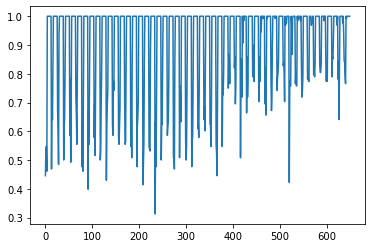

In [23]:
plt.plot(acc_list_bce[::]); 

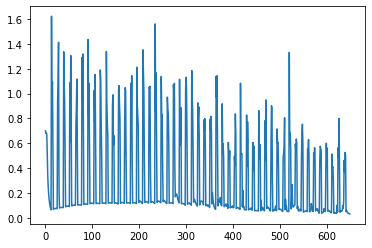

In [24]:
plt.plot(loss_list_bce[::]);

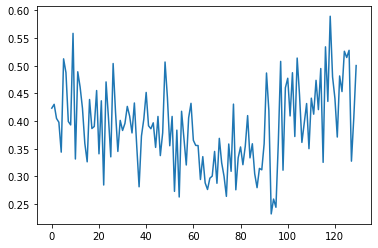

In [25]:
plt.plot(overall_val_loss_list_bce[::]);

In [ ]:
# BCE Loss
evaluate_metrics_on_set(model_bce, test_dataloader, BATCH_SIZE)
print("--"*10)
evaluate_metrics_on_set_new(model_bce, test_dataloader, BATCH_SIZE)

## Model CUSTOM loss

In [ ]:
model_custom = Combine()

cnt = 0
for param in model_custom.parameters():
    cnt+=1
    if(cnt==157): break   # 18 to freeze all mobile net block
    param.requires_grad = False

model_custom.to(device)

In [ ]:
loss_function_custom = CustomLoss()
optimizer_custom = torch.optim.Adam(model_custom.parameters(), lr=0.001)

In [ ]:
model_custom, (loss_list_custom, acc_list_custom, overall_val_loss_list_custom) = train_model(model_custom, loss_function_custom, optimizer_custom, train_dataloader, val_dataloader, BATCH_SIZE, 50, 5)

In [ ]:
plt.plot(acc_list_custom[::]); 

In [ ]:
plt.plot(loss_list_custom[::]);

In [ ]:
plt.plot(overall_val_loss_list_custom[::]);

In [ ]:
# Custom loss
evaluate_metrics_on_set(model_custom, test_dataloader, BATCH_SIZE)
print("--"*10)
evaluate_metrics_on_set_new(model_custom, test_dataloader, BATCH_SIZE)

## Model COMBINED loss

In [ ]:
model_combined = Combine()

cnt = 0
for param in model_combined.parameters():
    cnt+=1
    if(cnt==157): break   # 18 to freeze all mobile net block
    param.requires_grad = False

model_combined.to(device)

In [ ]:
optimizer_combined_bce = torch.optim.Adam(model_combined.parameters(), lr=0.001)
optimizer_combined_custom = torch.optim.Adam(model_combined.parameters(), lr=0.001)

In [ ]:
model_combined, (loss_list_cb, acc_list_cb, overall_val_loss_list_cb) = train_model(model_combined, loss_function_bce, optimizer_combined_bce, train_dataloader, val_dataloader, BATCH_SIZE, 30, 5)

In [ ]:
plt.plot(acc_list_cb[::]); 

In [ ]:
plt.plot(loss_list_cb[::]);

In [ ]:
plt.plot(overall_val_loss_list_cb[::]);

In [ ]:
model_combined, (loss_list_cc, acc_list_cc, overall_val_loss_list_cc) = train_model(model_combined, loss_function_custom, optimizer_combined_custom, train_dataloader, val_dataloader, BATCH_SIZE, 30, 5)

In [ ]:
plt.plot(acc_list_cc[::]); 

In [ ]:
plt.plot(loss_list_cc[::]);

In [ ]:
plt.plot(overall_val_loss_list_cc[::]);

In [ ]:
#Combined loss
evaluate_metrics_on_set(model_combined, test_dataloader, BATCH_SIZE)
print("--"*10)
evaluate_metrics_on_set_new(model_combined, test_dataloader, BATCH_SIZE)

## Get Pareto Metric

In [ ]:
threshold_number = 200
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
plt.plot(np.linspace(0.01, 1, threshold_number), threshold_list)

In [ ]:
def get_pareto_metrics_for_threshold(model, test_loader, batch_size ,threshold_list):
    fp_number_list = []
    fn_number_list = []
    delay_list = []
    fp_delay_list = []
    for threshold in threshold_list:
        # (positive_number, negative_number, test_loss, 
        #  test_acc, mean_delay, mean_fp_delay, fp_number, fn_number) = get_quality_metrics(model, test_loader, threshold)
        tp, tn, fp_number, fn_number, mean_delay, mean_fp_delay = evaluate_metrics_on_set(model, test_loader, batch_size, threshold)

        fp_number_list.append(fp_number)
        fn_number_list.append(fn_number)
        delay_list.append(mean_delay)
        fp_delay_list.append(mean_fp_delay)
    
    return fp_number_list, fn_number_list, delay_list, fp_delay_list

In [ ]:
_, _, delay_list_bce, fp_delay_list_bce = get_pareto_metrics_for_threshold(model_bce, test_dataloader, BATCH_SIZE, threshold_list)
print("BCE")

In [ ]:
_, _, delay_list_custom, fp_delay_list_custom = get_pareto_metrics_for_threshold(model_custom, test_dataloader, BATCH_SIZE, threshold_list)
print("CUSTOM")

In [ ]:
_, _, delay_list_combined, fp_delay_list_combined = get_pareto_metrics_for_threshold(model_combined, test_dataloader, BATCH_SIZE, threshold_list)
print("COMBINED")

In [ ]:
# with_lin_space
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_custom, delay_list_custom, '-o', label='LSTM. CustomLoss model')
plt.plot(fp_delay_list_bce, delay_list_bce, '-d', label='LSTM. BceLoss model')
plt.plot(fp_delay_list_combined, delay_list_combined, '-s', label='LSTM. CombinedLoss model')



plt.xlabel('Mean FP delay')
plt.ylabel('Mean delay')
#plt.yscale('log')
plt.legend(loc='upper left', fontsize=14);